In [1]:
import pandas as pd
import re

import os

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Januari 2019

Reporter: Samuel Åsgård

I denna fil kontrolleras vilket parti som är respektive partis "sämsta" samarbetspartner. Bakgrunden är att det är ett nytt regeringsbygge på G (får se ifall det håller) som troligen spikas på fredag. I detta bygge ska S samarbeta med C och L i budgetarbetet. Vi ställde oss därför hur lukerativa sådana samarbeten egentligen är. **Hur ser det ut för samrbeten mellan C och S, eller mellan L och S ifall man kollar i kommunerna?**

Koden bygger från början på det som arbetades fram inför valet 2018, och sedan bearbetades i och med reporter Samuels jobb i slutet av oktober 2018 (ifall MP straffades hårdare i samarbeten med Allianspartier eller med vänsterpartier, se mappen "mp_blockstyren" under 2018). 

Resultatet blev [förstauppslaget i tidning nr 3 2019](https://dagenssamhalle.e-pages.pub/titles/dagenssamhalle/8599/publications/362/pages/2), och finns [som webbartikel här](https://dagenssamhalle.se/nyhet/centern-tappar-pa-mittensamarbete-25832). Liberalerna tjänar på samarbeten med S i kommunerna, i varje fall jämfört med ifall de samarbetar med övriga borgerliga partier. Centerpartiet gör det inte. Samarbete med S straffar sig jämfört samarbete med övriga borgerliga.

Men först måste data hämats från Valmyndigheten.

### Hämta data

Skapa relevanta mappar:

In [2]:
from startup_tools import folder_maker
folder_maker(years=['2010','2014','2018'])

Hämta alla grundfiler (xml-format) från Valmyndigheten. Kan ta upp till ett par minuter:

In [3]:
%%time
from startup_tools import xml_data_fetcher
xml_data_fetcher(count_type='slutresultat')

CPU times: user 5.05 s, sys: 2.53 s, total: 7.58 s
Wall time: 48 s


Extrahera och formattera data:

In [4]:
from startup_tools import ExtractData
E = ExtractData()

In [5]:
years = ['2010','2014','2018']

for year in years:
    E.fast_elec_calc(year=year,count_type="slutresultat")
    E.fast_particip_calc(year=year,count_type="slutresultat")
    #E.muni_elec_meta_data(year=year)

E.all_parties(count_type="slutresultat")
E.macro_results(count_type="slutresultat") 

### Beräkningar

In [6]:
def col_shaper(cols):
    """Den här funktionen tar våra dataframes kolumner och omformar \
dessa till en dictionary med önskad utformning. Så alla resultat \
från denna funktion vet att varannan kolumn bygger på äldre \
valresultat. Denna funktaion ger varannan kolumn ändelsen \
'_väljarmandat' och varannan '_valresultat' i en dictionary. \
Se cellen direkt nedanför för exempel."""
    
    # det är endast de kolumner med valresultatsdata som ska formatteras, 
    # dessa har alltid en årsändelse, t ex "mandat_2006"
    formatted_cols = [col for col in cols if '_20' in col]
    
    # De övriga ska inte formatteras
    old_cols = [col for col in cols if '_20' not in col]
    
    # sortera kolumnerna som ska formatteras
    formatted_cols.sort()
    
    # spara hur de oformatterade kolumnerna ser ut
    olds = formatted_cols.copy()
    
    # lägg till de kolumner som inte ska formatteras
    [olds.append(col) for col in old_cols]
    
    counter = 1
    for i in range(len(formatted_cols)):
        # Hitta alla kolumner som har en sifferändelse i sig i 
        # listan på kolumner som ska formatteras
        r = re.findall("\w+(_\d+)",formatted_cols[i])[0]
        
        if counter % 2 != 0:
            # Ifall det är 1a, 2a, 3e etc kolumnen, gör såhär:
            formatted_cols[i] = formatted_cols[i].replace(r,"_väljarmandat")
        else:
            # annars gör såhär:
            formatted_cols[i] = formatted_cols[i].replace(r,"_valresultat")
        counter += 1
    
    # Lägg till de kolumner som inte skulle formatteras till listan på de
    # formatterade kolumnerna:
    [formatted_cols.append(col) for col in old_cols]
    
    # återge en dictionary på resultat:
    return dict(zip(olds,formatted_cols))
        

Nu till att hämta alla datafiler beräknade data. Och återigen, funktionerna som används är ursprungligen från 2018 års valanalys (se mappen "valet_2018", eller på min [github](https://github.com/johan-ekman/valet_2018)).

**Först fromattera fram en bra grunddata**

In [8]:
from util import gov_mandates,block_gov_count

# 2006-2010
govs=gov_mandates(2006)
df_2006_2010 = block_gov_count(govs,
                               value='mandat',
                               elec_year=2010,
                               compare_year=2006,
                               research_data=True)
df_2006_2010['mandatperiod'] = '2006_2010'


# 2010-2014
govs=gov_mandates(2010)
df_2010_2014 = block_gov_count(govs,
                               value='mandat',
                               elec_year=2014,
                               compare_year=2010,
                               research_data=True)
df_2010_2014['mandatperiod'] = '2010_2014'


# 2014-2018
govs=gov_mandates(2014)
df_2014_2018 = block_gov_count(govs,
                               value='mandat',
                               elec_year=2018,
                               compare_year=2014,
                               research_data=True)
df_2014_2018['mandatperiod'] = '2014_2018'



In [9]:
from util import all_elec_years

In [10]:
frames = [df_2006_2010,df_2010_2014,df_2014_2018]

In [11]:
alla_perioder = pd.DataFrame()
for frame in frames:
    # Döp om alla kolumner:
    frame.columns = frame.columns.map(col_shaper(frame.columns))
    
    alla_perioder=pd.concat([alla_perioder,frame])
    

In [12]:
valresultat=alla_perioder.mandatperiod.unique().tolist()

In [13]:
valresultat

['2006_2010', '2010_2014', '2014_2018']

Här endast för att döpa om mandatperioderna efter respektive valår:

In [14]:
alla_perioder.mandatperiod=alla_perioder.mandatperiod.map(dict(zip(valresultat,[2006,2010,2014,2018])))

In [15]:
res = alla_perioder.loc[:,['kommun',
                                'mandatperiod',
                                'parti',
                                'block',
                                'röster_väljarmandat',
                                'summa_röster_väljarmandat',
                                'röster_valresultat',
                                'summa_röster_valresultat']]

In [16]:
res.head()

,kommun,mandatperiod,parti,block,röster_väljarmandat,summa_röster_väljarmandat,röster_valresultat,summa_röster_valresultat
0,Ale,2006,S,V,6138.0,15784,5986.0,17257
1,Ale,2006,MP,V,621.0,15784,860.0,17257
2,Ale,2006,V,V,1131.0,15784,962.0,17257
3,Alingsås,2006,C,A,1653.0,23273,1310.0,24959
4,Alingsås,2006,M,A,4343.0,23273,5940.0,24959


In [17]:
res[['kommun','mandatperiod']].drop_duplicates().mandatperiod.value_counts()

2014    272
2006    256
2010    253
Name: mandatperiod, dtype: int64

Det är färre än 290 kommuner varje år. Anledningen är att funktionerna filtrerar bort kommuner där endast ett parti styr, och eller ifall det endast är ett samarbetet med ett av riksdagspartierna och ett (eller flera) övriga lokala partier. Styren med endast lokala partier filtreras också bort.

In [18]:
for col in ['summa_röster_väljarmandat','summa_röster_valresultat']:
    res[col] = pd.to_numeric(res[col])

In [19]:
def comp(df,party,block=None,procentenheter=True,num_coop=False,mandatperiod=None):
    """Denna funktion tar tabellen över styren och ett valfritt parti \
som argument. Den återger sedan hur det gått för alla övriga riksdags- \
partier att samarbete med detta parti. Så, till exempel ifall \
party='S' så återges en sorterad lista (pandas series) på de partier \
som samarbetat med det partiet någon gång de senaste tre mandat- \
perioderna, och hur det sedan gått för dem i följande val efter de \
ingått i samarbete. Listan är sorterad efter de partier som straffades \
hårdast av väljarna efter samarbetet.

PARAMETERS
----------

df : bearbetad grunddata

party : partiet man vill kolla hur andra partier drabbas av samarbete med

block : ifall man vill filtrera fram grunddata efter block


Returns: pandas series (float64)
    
"""
    
    partier = ['M','C','L','KD','S','V','MP']

    df = df.loc[df['parti'].isin(partier)]
    
    if block:
        df = df.loc[df['block']==block]
    if mandatperiod:
        df = df.loc[df['mandatperiod']==mandatperiod]
    
    df = df.drop('block',axis=1)
    
    tmp = df.loc[df['parti']==party][['kommun','mandatperiod']]
    df1 = tmp.merge(df.loc[df['parti']!=party],on=['kommun','mandatperiod'],how='left')
    #return df1
    tmp = df1.groupby('parti').sum()
    
    
    
    tmp['procent_väljarmandat'] = ((tmp['röster_väljarmandat'] / tmp['summa_röster_väljarmandat'])*100).round(2)
    tmp['procent_valresultat'] = ((tmp['röster_valresultat'] / tmp['summa_röster_valresultat'])*100).round(2)

    if procentenheter:
        tmp[party] = tmp['procent_valresultat'] - tmp['procent_väljarmandat']
    else:
        tmp[party] = (((tmp['procent_valresultat'] / tmp['procent_väljarmandat'])-1)*100).round(2)
        
    if num_coop:
        return df.parti.value_counts()\
                 .reset_index()\
                 .rename(columns={'index':'parti',
                                  'parti':party})\
                 .set_index('parti')[party]
    else:
        return tmp[party]
    

In [20]:
test = comp(res,'S')

In [21]:
comp(res,'V',mandatperiod=2014,procentenheter=False)

parti
C     16.02
KD    14.44
L      1.71
M     -3.67
MP   -40.61
S    -10.39
Name: V, dtype: float64

In [22]:
partier = ['M', 'C', 'L', 'KD', 'S', 'V', 'MP']

In [23]:
tmp = pd.DataFrame(index=partier)
for parti in partier:
    tmp = pd.concat([tmp,comp(res,parti,procentenheter=False,mandatperiod=2006)],axis=1)

In [24]:
tmp.loc[partier,:]

,M,C,L,KD,S,V,MP
M,NaN,7.21,6.19,6.42,11.01,4.23,16.54
C,-15.72,NaN,-16.24,-16.43,-18.13,-9.90,-20.60
L,-1.82,-2.44,NaN,-1.86,-0.84,0.23,-7.51
KD,-22.51,-22.77,-22.65,NaN,-21.15,-32.79,-24.84
S,-5.38,-5.80,-7.85,-8.21,NaN,-6.40,-7.53
V,-29.25,-27.85,-24.43,-44.59,-10.11,NaN,-9.64
MP,29.78,30.69,29.46,29.88,31.68,31.37,NaN


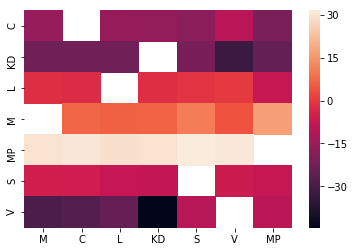

In [25]:
sns.heatmap(tmp)

In [26]:
from pandas import ExcelWriter

In [27]:
os.makedirs('res')

In [28]:
writer = ExcelWriter('res/sämsta_partnern_andelstapp.xlsx')

In [29]:
tmp = pd.DataFrame(index=partier)
for parti in partier:
    tmp = pd.concat([tmp,comp(res,parti,procentenheter=False)],axis=1)
tmp.loc[partier,:].to_excel(writer,'i_andelar')

In [30]:
tmp = pd.DataFrame(index=partier)
for parti in partier:
    tmp = pd.concat([tmp,comp(res,parti,procentenheter=True)],axis=1)
tmp.loc[partier,:].to_excel(writer,'i_procentenheter')

In [31]:
tmp = pd.DataFrame(index=partier)
for parti in partier:
    tmp = pd.concat([tmp,comp(res,parti,num_coop=True)],axis=1)
tmp.loc[partier,:].to_excel(writer,'antal_samarbeten')

In [32]:
writer.save()

In [33]:
tmp = pd.DataFrame(index=partier)
for parti in partier:
    tmp = pd.concat([tmp,comp(res,parti,procentenheter=False,block='BL')],axis=1)
tmp = tmp.loc[partier,:]

In [34]:
tmp

,M,C,L,KD,S,V,MP
M,NaN,-5.51,-5.98,-3.16,-9.03,0.54,-10.64
C,-0.71,NaN,-0.12,8.81,4.33,6.39,7.83
L,-17.03,-6.63,NaN,-12.73,-3.14,-14.21,2.77
KD,-0.53,14.02,8.39,NaN,13.42,0.00,13.98
S,-8.65,-11.19,-11.77,-11.10,NaN,-11.30,-13.04
V,-23.68,-1.89,-8.40,-3.39,6.44,NaN,-2.84
MP,-16.86,-31.61,-27.53,-36.40,-32.30,-30.89,NaN


### Testare?

In [35]:
def ex(df,\
         party,\
         block=None,\
         procentenheter=True,\
         num_coop=False,\
         mandatperiod=2014,
         samarbetspartier=[],\
         munis=False):
    """Denna funktion tar tabellen över styren och ett valfritt parti \
som argument. Den återger sedan hur det gått för alla övriga riksdags- \
partier att samarbete med detta parti. Så, till exempel ifall \
party='S' så återges en sorterad lista (pandas series) på de partier \
som samarbetat med det partiet någon gång de senaste tre mandat- \
perioderna, och hur det sedan gått för dem i följande val efter de \
ingått i samarbete. Listan är sorterad efter de partier som straffades \
hårdast av väljarna efter samarbetet.

PARAMETERS
----------

df : bearbetad grunddata

party : partiet man vill kolla hur andra partier drabbas av samarbete med

block : ifall man vill filtrera fram grunddata efter block


Returns: pandas series (float64)
    
"""
    
    partier = ['M','C','L','KD','S','V','MP']

    df = df.loc[df['parti'].isin(partier)]
    
    if block:
        df = df.loc[df['block']==block]
    if mandatperiod:
        df = df.loc[df['mandatperiod']==mandatperiod]
    
    df = df.drop('block',axis=1)
    #return df
    tmp = df.loc[df['parti']==party][['kommun','mandatperiod']]
    df1 = tmp.merge(df.loc[df['parti']!=party],on=['kommun','mandatperiod'],how='left').dropna()
    
    if samarbetspartier:
        samarbetspartier.append('MP')
        partier = [x for x in partier if x not in samarbetspartier]
        samarbetspartier.remove('MP')
        bad_munis = df1.loc[(df1['parti'].isin(partier)),['kommun','mandatperiod']].drop_duplicates().kommun.tolist()
        df1 = df1.loc[~df1['kommun'].isin(bad_munis)]
        #return df1
    
    if munis:
        return df1
    tmp = df1.groupby('parti').sum()
    
    
    
    tmp['procent_väljarmandat'] = ((tmp['röster_väljarmandat'] / tmp['summa_röster_väljarmandat'])*100)
    tmp['procent_valresultat'] = ((tmp['röster_valresultat'] / tmp['summa_röster_valresultat'])*100)

    if procentenheter:
        tmp[party] = (tmp['procent_valresultat'] - tmp['procent_väljarmandat']).round(2)
    else:
        tmp[party] = (((tmp['procent_valresultat'] / tmp['procent_väljarmandat'])-1)*100).round(2)
        
    if num_coop:
        return df.parti.value_counts()\
                 .reset_index()\
                 .rename(columns={'index':'parti',
                                  'parti':party})\
                 .set_index('parti')[party]
    else:
        return tmp[party]
    

In [36]:
kommunerna = ex(res,"S",mandatperiod=2014,samarbetspartier=['C','L'],procentenheter=True,munis=True)

In [37]:
kommunerna['procent_väljarmandat'] = ((kommunerna['röster_väljarmandat'] / kommunerna['summa_röster_väljarmandat'])*100)
kommunerna['procent_valresultat'] = ((kommunerna['röster_valresultat'] / kommunerna['summa_röster_valresultat'])*100)
kommunerna['resultat_2014_2018'] = (kommunerna['procent_valresultat'] - kommunerna['procent_väljarmandat']).round(2)


In [38]:
munis = kommunerna.kommun.drop_duplicates()

In [39]:
munis = res.loc[(res['kommun'].isin(munis)&(res['mandatperiod']==2014))]

In [40]:
kolla=munis.kommun.value_counts().reset_index().loc[munis.kommun.value_counts().reset_index()['kommun']==2]['index'].tolist()

In [41]:
kolla=munis.loc[(munis.kommun.isin(kolla))&(munis['parti']=='MP'),'kommun'].tolist()

In [42]:
bort = munis.loc[(munis.kommun.isin(kolla)),'kommun'].drop_duplicates().tolist()

In [43]:
kommunerna = munis.loc[~munis['kommun'].isin(bort)]

In [44]:
kommunerna['procent_2014'] = ((kommunerna['röster_väljarmandat'] / kommunerna['summa_röster_väljarmandat'])*100)
kommunerna['procent_2018'] = ((kommunerna['röster_valresultat'] / kommunerna['summa_röster_valresultat'])*100)
kommunerna['resultat_2014_2018'] = (kommunerna['procent_2018'] - kommunerna['procent_2014']).round(2)


In [45]:
kommunerna.columns

Index(['kommun', 'mandatperiod', 'parti', 'block', 'röster_väljarmandat',
       'summa_röster_väljarmandat', 'röster_valresultat',
       'summa_röster_valresultat', 'procent_2014', 'procent_2018',
       'resultat_2014_2018'],
      dtype='object')

In [46]:
kommunerna.sort_values('resultat_2014_2018',ascending=True).to_excel('res/SCLMP_kommunerna.xlsx',index=False)

In [47]:
kommunerna = pd.read_excel('res/SCLMP_kommunerna.xlsx')

In [48]:
tmp = pd.DataFrame(index=partier)
for parti in partier:
    tmp = pd.concat([tmp,ex(res,parti,mandatperiod=2014,procentenheter=True)],axis=1)
tmp = tmp.loc[partier,:]

In [49]:
tmp.to_excel('res/alla_samarbeten.xlsx')

In [50]:
results_CLS = pd.DataFrame()
for year in [2006,2010,2014]:
    results_CLS[f'S_styrda_kommuner_{year}'] = ex(res,"S",mandatperiod=year,samarbetspartier=['C','L'],procentenheter=True)

In [51]:
results_CLS

,S_styrda_kommuner_2006,S_styrda_kommuner_2010,S_styrda_kommuner_2014
parti,,,
C,-2.86,-1.12,0.87
L,0.54,-1.16,0.59
MP,1.27,0.78,-2.83


In [52]:
def alla_kommuner(df,\
                  block=None,\
         procentenheter=True,\
         mandatperiod=2014):
    
    partier = ['M','C','L','KD','S','V','MP']

    df = df.loc[df['parti'].isin(partier)]
    
    df = df.loc[df['mandatperiod']==mandatperiod]
    
    if block:
        df = df.loc[df['block']==block]
    
    tmp = df.groupby('parti').sum()
    
    
    
    tmp['procent_väljarmandat'] = ((tmp['röster_väljarmandat'] / tmp['summa_röster_väljarmandat'])*100)
    tmp['procent_valresultat'] = ((tmp['röster_valresultat'] / tmp['summa_röster_valresultat'])*100)

    if procentenheter:
        tmp[f'resultat_{mandatperiod}'] = (tmp['procent_valresultat'] - tmp['procent_väljarmandat']).round(2)
    else:
        tmp[f'resultat_{mandatperiod}'] = (((tmp['procent_valresultat'] / tmp['procent_väljarmandat'])-1)*100).round(2)
    return tmp[f'resultat_{mandatperiod}']    

In [53]:
resultat_styren = pd.DataFrame()
for year in [2006,2010,2014]:
    resultat_styren[f'alla_styren_{year}'] = alla_kommuner(res,mandatperiod=year,procentenheter=True)

In [54]:
resultat_styren

,alla_styren_2006,alla_styren_2010,alla_styren_2014
parti,,,
C,-1.62,0.03,1.34
KD,-1.39,-0.53,1.42
L,-0.15,-1.73,-0.03
M,1.66,-5.91,-1.45
MP,1.56,0.55,-3.47
S,-2.44,-2.99,-3.77
V,-0.81,1.14,1.72


Efter block:

In [55]:
efter_block = pd.DataFrame()
for year in [2006,2010,2014]:
    efter_block[f'alla_styren_{year}'] = alla_kommuner(res,block='A',mandatperiod=year)
efter_block.to_excel('res/A_block.xlsx')
efter_block

,alla_styren_2006,alla_styren_2010,alla_styren_2014
parti,,,
C,-1.55,0.08,1.55
KD,-1.40,-0.52,1.50
L,-0.16,-1.71,-0.13
M,1.65,-5.95,-1.56
MP,1.23,0.57,-2.84


In [56]:
efter_block = pd.DataFrame()
for year in [2006,2010,2014]:
    efter_block[f'alla_styren_{year}'] = alla_kommuner(res,block='BL',mandatperiod=year)
efter_block.to_excel('res/BL_block.xlsx')

In [57]:
efter_block

,alla_styren_2006,alla_styren_2010,alla_styren_2014
parti,,,
C,-2.39,-0.55,1.03
KD,-1.43,-1.03,1.18
L,-0.04,-2.10,0.22
M,1.66,-4.92,-1.07
MP,1.04,0.69,-2.60
S,-2.17,-1.65,-4.66
V,-2.60,0.16,0.27


In [58]:
efter_block = pd.DataFrame()
for year in [2006,2010,2014]:
    efter_block[f'S_styrda_kommuner_{year}'] = alla_kommuner(res,mandatperiod=year,procentenheter=True)

In [59]:
results_CLS.to_excel('res/SCLMP_kommuner.xlsx')
results_CLS

,S_styrda_kommuner_2006,S_styrda_kommuner_2010,S_styrda_kommuner_2014
parti,,,
C,-2.86,-1.12,0.87
L,0.54,-1.16,0.59
MP,1.27,0.78,-2.83


In [60]:
resultat_styren.to_excel("res/alla_styren.xlsx")
resultat_styren

,alla_styren_2006,alla_styren_2010,alla_styren_2014
parti,,,
C,-1.62,0.03,1.34
KD,-1.39,-0.53,1.42
L,-0.15,-1.73,-0.03
M,1.66,-5.91,-1.45
MP,1.56,0.55,-3.47
S,-2.44,-2.99,-3.77
V,-0.81,1.14,1.72
